In [6]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 

In [10]:
model = AbstractModel()
model.N =Param(mutable=True, default=20) 
model.i = RangeSet(1,model.N)
model.j = Set(initialize=model.i)
model.U = Var(model.i,model.j, within=Binary)
model.flow = Var(model.i,model.j,bounds=(0,model.N), within=NonNegativeReals)
model.G = Var(bounds=(0,model.N), within=NonNegativeReals)


model.OF = Var(within=NonNegativeReals, initialize=5)
def initval(model,i):
    return random.uniform(0,1)
model.Xloc=Param(model.i,  within=NonNegativeReals, initialize=initval,mutable=True)
model.Yloc=Param(model.i,  within=NonNegativeReals, initialize=initval, mutable=True)

def Rule_D(model,i,j):
    return sqrt((model.Xloc[i]-model.Xloc[j])**2+(model.Yloc[i]-model.Yloc[j])**2)
                
model.D=Param(model.i,model.j,  within=NonNegativeReals,initialize=Rule_D, mutable=True)

def rule_C1(model,i):
    if i==1:
        return model.G-i/model.N==sum(model.flow[i,j]-model.flow[j,i] if i!=j else 0 for j in model.j)
    else:
        return        -i/model.N==sum(model.flow[i,j]-model.flow[j,i] if i!=j else 0 for j in model.j)
model.C1   = Constraint(model.i,rule=rule_C1)

def rule_C2(model,i,j):
    if i!=j:
        return model.flow[j,i]<=model.U[i,j]*model.N
    else:
        return Constraint.Skip
    
model.C2   = Constraint(model.i,model.j,rule=rule_C2)

def rule_C3(model,i):
    return sum(model.U[i,j] if i!=j else 0 for j in model.j)==1
model.C3   = Constraint(model.i,rule=rule_C3)

def rule_C4(model,j):
    return sum(model.U[i,j] if i!=j else 0 for i in model.i)==1
model.C4   = Constraint(model.j,rule=rule_C4)

def rule_OF(model):
    return model.OF==sum(model.U[r,c]*model.D[r,c] if r!=c else 0 for r in model.i for c in model.j)
model.C   = Constraint(rule=rule_OF)

model.obj1 = Objective(expr=model.OF, sense=minimize)

In [11]:
opt = SolverFactory('glpk')

In [12]:
model.N=20
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.obj1))

OF=  4.17115783151148


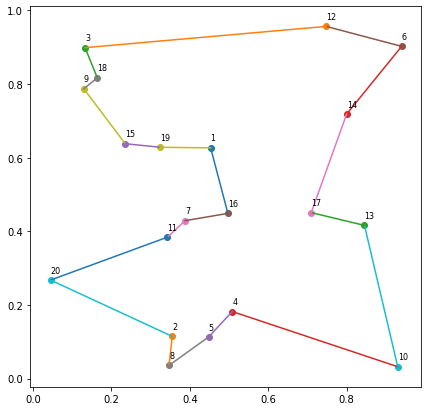

In [13]:
fig = plt.figure(figsize=(7,7))
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i))
    plt.text(value(instance.Xloc[i]),0.02+value(instance.Yloc[i]), str(i), fontsize=8)

for i in instance.i:
    for j in instance.j:
        if i!=j:
            if value(instance.U[i,j])==1:
                plt.plot([value(instance.Xloc[i]),value(instance.Xloc[j])],[value(instance.Yloc[i]),value(instance.Yloc[j])])
                